# Percentile Forecast Optimization

This notebook focuses on percentile-based forecasts.
It optimizes percentile targets first without aggregation, then with an aggregation window.


## Setup


In [47]:
import pandas as pd
import random
from dataclasses import replace

from replenishment import (
    PercentileForecastOptimizationPolicy,
    RopPercentileForecastOptimizationPolicy,
    build_percentile_forecast_candidates_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    evaluate_aggregation_and_forecast_target_costs,
    evaluate_forecast_target_costs,
    generate_standard_simulation_rows,
    optimize_aggregation_and_forecast_targets,
    optimize_forecast_targets,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    split_standard_simulation_rows,
    simulate_replenishment_with_aggregation,
    standard_simulation_rows_from_dataframe,
    standard_simulation_rows_to_dataframe,
)

### Policy cadence parameters (review cycle + forecast horizon)

Set the order cadence (**review_period**) and the coverage window (**forecast_horizon**, excluding lead time).
The policy uses a total horizon of **lead_time + forecast_horizon**.


In [48]:
review_period = 3
forecast_horizon = 3
rmse_window = review_period  # optional; defaults to review_period


## Generate Sample Data


In [49]:
history_mean = 18
history_std = 10
forecast_mean = 17
forecast_std = 2
replenishment_start_period = 90

rows = generate_standard_simulation_rows(
    n_unique_ids=3,
    periods=120,
    forecast_start_period=replenishment_start_period,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    initial_on_hand=15,
    current_stock=15,
    lead_time=3,
   # seed=7,
    holding_cost_per_unit=1,
    stockout_cost_per_unit=100,
    order_cost_per_order=10,
    percentile_multipliers={
        "p10": 0.6,
        "p15": 0.65,
        "p20": 0.70,
        "p25": 0.75,
        "p30": 0.80,
        "p35": 0.85,
        "p40": 0.90,
        "p45": 0.95,
        "p50": 1.0,
        "p55": 1.05,
        "p60": 1.10,
        "p65": 1.15,
        "p70": 1.20,
        "p75": 1.25,
        "p80": 1.30,
        "p85": 1.35,
        "p90": 1.40,
    },
)
df = standard_simulation_rows_to_dataframe(rows, library="pandas")


## Split Backtest vs Forecast


In [50]:
backtest_rows, forecast_rows = split_standard_simulation_rows(rows)


# Add simulated actuals for the forecast/replenishment period so we can measure lost sales.
rng = random.Random(7)

def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

forecast_rows_actuals = [
    replace(row, actuals=_sample_int(history_mean, history_std), demand=_sample_int(history_mean, history_std))
    for row in forecast_rows
]
forecast_rows = forecast_rows_actuals

# Rebuild df so plots include actuals in replenishment period.
df = standard_simulation_rows_to_dataframe(
    backtest_rows + forecast_rows, library="pandas"
)

## Step 1: Optimize Percentile Target (No Aggregation)


In [51]:
percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    backtest_rows,
    include_mean=True,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
percentile_costs = evaluate_forecast_target_costs(percentile_configs)
percentile_cost_rows = [
    {"unique_id": uid, "target": target, "total_cost": cost}
    for uid, targets in percentile_costs.items()
    for target, cost in targets.items()
]
percentile_cost_df = pd.DataFrame(percentile_cost_rows)
percentile_cost_df


,unique_id,target,total_cost
0,A,p10,44269.0
1,A,p15,38340.0
2,A,p20,32537.0
3,A,p25,26791.0
4,A,p30,22644.0
5,A,p35,19204.0
6,A,p40,15799.0
7,A,p45,13423.0
8,A,p50,11571.0
9,A,p55,10744.0


In [52]:
percentile_result = optimize_forecast_targets(percentile_configs)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    target = percentile_result[unique_id].target
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=1,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    percentile_target={
        uid: percentile_result[uid].target
        for uid in forecast_percentile_simulations
    },
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
percentile_decision_df = replenishment_decision_rows_to_dataframe(
    percentile_decision_rows,
    library="pandas",
)
percentile_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2031-05-24,91,23,21.000000,44.333333,63.0,126.0,0,15,...,0,91,0,8,None,3,3,3,3,p75
1,A,2031-06-23,1,15,22.333333,44.000000,67.0,134.0,0,0,...,0,92,0,15,None,3,3,3,3,p75
2,A,2031-07-23,0,16,23.666667,44.333333,71.0,142.0,0,0,...,0,92,0,16,None,3,3,3,3,p75
3,A,2031-08-22,16,22,23.333333,43.666667,70.0,140.0,91,91,...,69,17,0,0,None,3,3,3,3,p75
4,A,2031-09-21,16,20,21.666667,43.333333,65.0,130.0,1,70,...,50,32,0,0,None,3,3,3,3,p75


### Plot (No Aggregation)


0      8
1     15
2     16
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     1
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Percentile decisions (no aggregation)'}, xlabel='Date', ylabel='Units'>

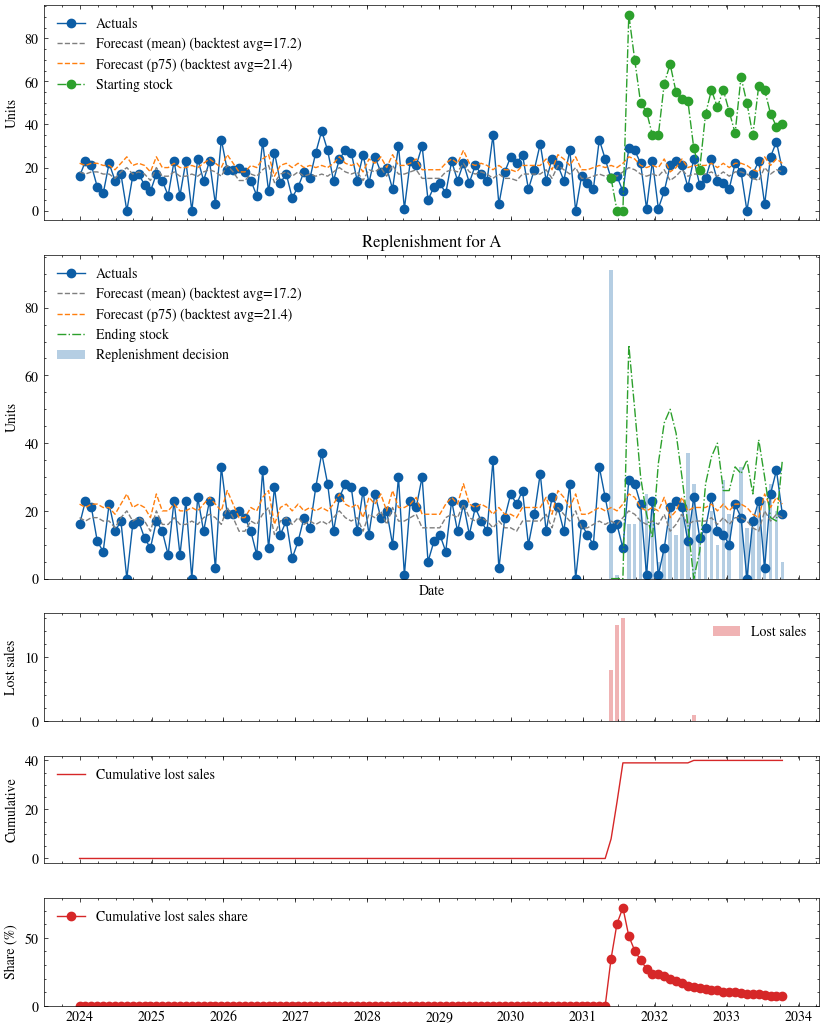

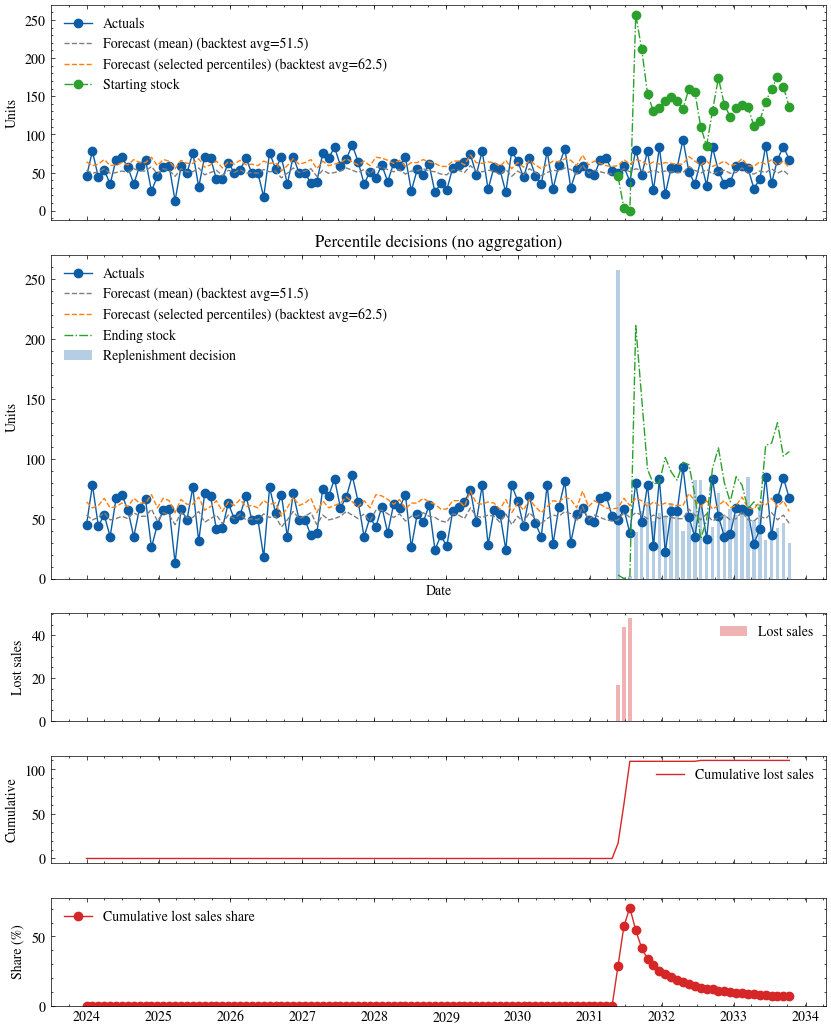

In [53]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (no aggregation)",
)


## Step 2: Optimize Aggregation Window + Percentile Target


In [54]:
agg_percentile_results = optimize_aggregation_and_forecast_targets(
    percentile_configs,
    candidate_windows=[7, 8, 9, 10],
)

agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_percentile_results.items()
}

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
    review_period=agg_windows,
    forecast_horizon=agg_windows,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    choice = agg_percentile_results[unique_id]
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

agg_percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    aggregation_window={
        uid: agg_percentile_results[uid].window
        for uid in forecast_percentile_simulations
    },
    percentile_target={
        uid: agg_percentile_results[uid].target
        for uid in forecast_percentile_simulations
    },
    review_period=agg_windows,
    forecast_horizon=agg_windows,
    rmse_window=agg_windows,
)
agg_percentile_decision_df = replenishment_decision_rows_to_dataframe(
    agg_percentile_decision_rows,
    library="pandas",
)
agg_percentile_decision_df.head(10)


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2031-05-24,182,23,18.000000,37.666667,54.0,108.0,0,15,...,0,182,0,8,None,3,3,3,3,p55
1,A,2031-06-23,0,15,19.000000,37.333333,57.0,114.0,0,0,...,0,182,0,15,None,3,3,3,3,p55
2,A,2031-07-23,0,16,20.000000,37.666667,60.0,120.0,0,0,...,0,182,0,16,None,3,3,3,3,p55
3,A,2031-08-22,0,22,19.666667,37.000000,59.0,118.0,182,182,...,160,0,0,0,None,3,3,3,3,p55
4,A,2031-09-21,0,20,18.333333,36.666667,55.0,110.0,0,160,...,140,0,0,0,None,3,3,3,3,p55
5,A,2031-10-21,0,20,17.666667,35.000000,53.0,106.0,0,140,...,120,0,0,0,None,3,3,3,3,p55
6,A,2031-11-20,0,27,17.333333,34.666667,52.0,104.0,0,120,...,93,0,0,0,None,3,3,3,3,p55
7,A,2031-12-20,109,23,18.333333,35.666667,55.0,110.0,0,93,...,70,109,0,0,None,3,3,3,3,p55
8,A,2032-01-19,0,1,17.333333,35.333333,52.0,104.0,0,70,...,69,109,0,0,None,3,3,3,3,p55
9,A,2032-02-18,0,13,17.333333,35.666667,52.0,104.0,0,69,...,56,109,0,0,None,3,3,3,3,p55


### Plot (Optimized Aggregation)


0      8
1     15
2     16
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Percentile decisions (optimized aggregation)'}, xlabel='Date', ylabel='Units'>

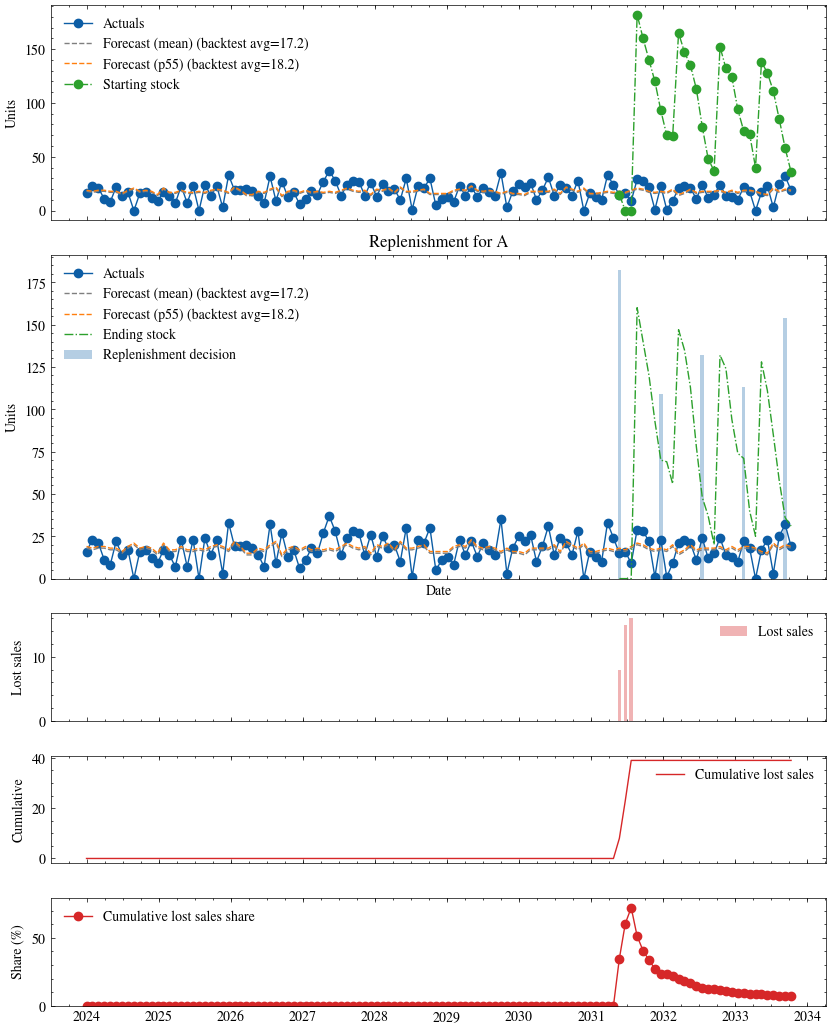

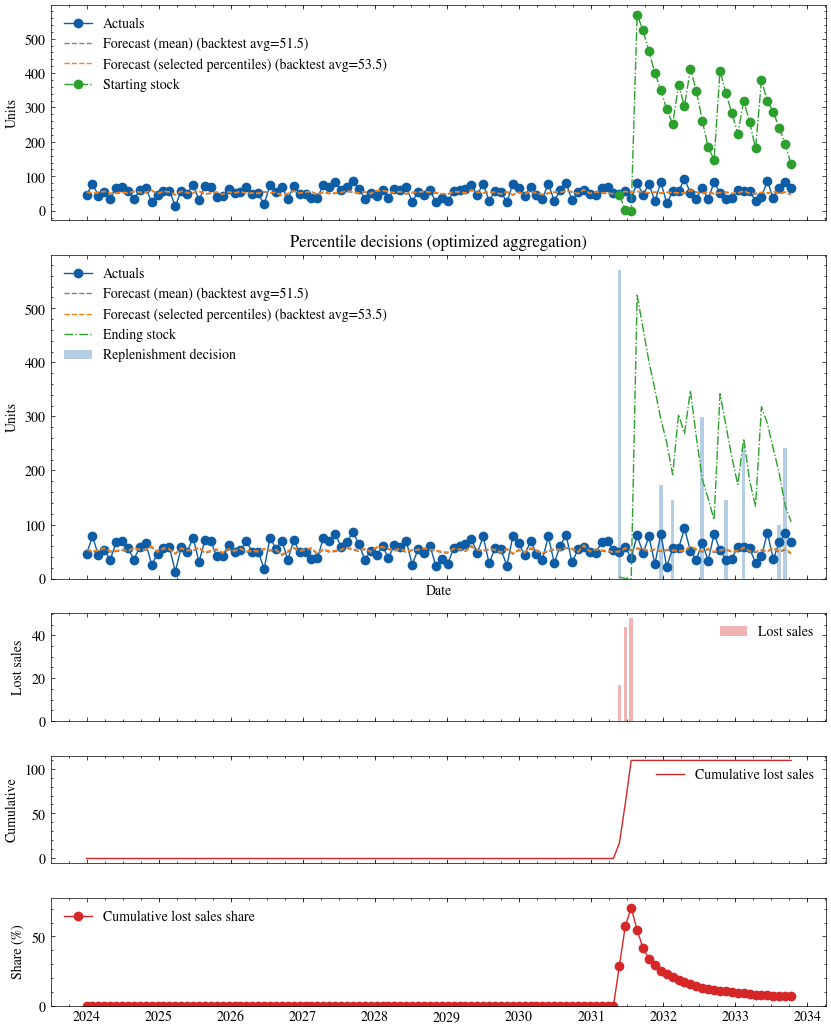

In [55]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, agg_percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    agg_percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (optimized aggregation)",
)


## ROP policy (percentile targets)
This section optimizes percentile targets using a reorder-point trigger.


In [56]:
rop_percentile_results = optimize_forecast_targets(
    percentile_configs,
    policy_mode="rop",
)
rop_percentile_results


{'A': PercentileForecastOptimizationResult(target='p90', policy=RopPercentileForecastOptimizationPolicy(forecast=[25, 24, 25, 25, 24, 24, 21, 25, 28, 24, 25, 24, 20, 28, 22, 22, 25, 22, 22, 24, 22, 25, 27, 25, 22, 29, 25, 20, 20, 24, 22, 27, 29, 18, 24, 25, 22, 25, 22, 24, 22, 24, 22, 25, 28, 25, 24, 25, 20, 27, 25, 28, 22, 29, 24, 24, 25, 27, 21, 21, 21, 21, 25, 27, 25, 31, 25, 24, 25, 24, 21, 24, 21, 21, 20, 24, 24, 24, 24, 27, 21, 29, 27, 24, 28, 21, 21, 22, 24, 22], lead_time=3, aggregation_window=3, review_period=3, forecast_horizon=3), simulation=SimulationResult(snapshots=[InventorySnapshot(period=0, starting_on_hand=15, demand=16, received=0, ending_on_hand=0, backorders=0, order_placed=143, on_order=143), InventorySnapshot(period=1, starting_on_hand=0, demand=23, received=0, ending_on_hand=0, backorders=0, order_placed=0, on_order=143), InventorySnapshot(period=2, starting_on_hand=0, demand=21, received=0, ending_on_hand=0, backorders=0, order_placed=0, on_order=143), Inventor

In [57]:
rop_forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
rop_percentile_simulations = {}
for unique_id, config in rop_forecast_percentile_configs.items():
    target = rop_percentile_results[unique_id].target
    policy = RopPercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[target],
        lead_time=config.lead_time,
    )
    rop_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=1,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
rop_percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    rop_percentile_simulations,
    percentile_target={
        uid: rop_percentile_results[uid].target
        for uid in rop_percentile_simulations
    },
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
rop_percentile_decision_df = replenishment_decision_rows_to_dataframe(
    rop_percentile_decision_rows,
    library="pandas",
)
rop_percentile_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2031-05-24,102,23,23.666667,50.000000,71.0,142.0,0,15,...,0,102,0,8,None,3,3,3,3,p90
1,A,2031-06-23,0,15,25.000000,49.333333,75.0,150.0,0,0,...,0,102,0,15,None,3,3,3,3,p90
2,A,2031-07-23,0,16,26.666667,50.000000,80.0,160.0,0,0,...,0,102,0,16,None,3,3,3,3,p90
3,A,2031-08-22,0,22,26.333333,49.000000,79.0,158.0,102,102,...,80,0,0,0,None,3,3,3,3,p90
4,A,2031-09-21,32,20,24.333333,48.666667,73.0,146.0,0,80,...,60,32,0,0,None,3,3,3,3,p90


0      8
1     15
2     16
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     4
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

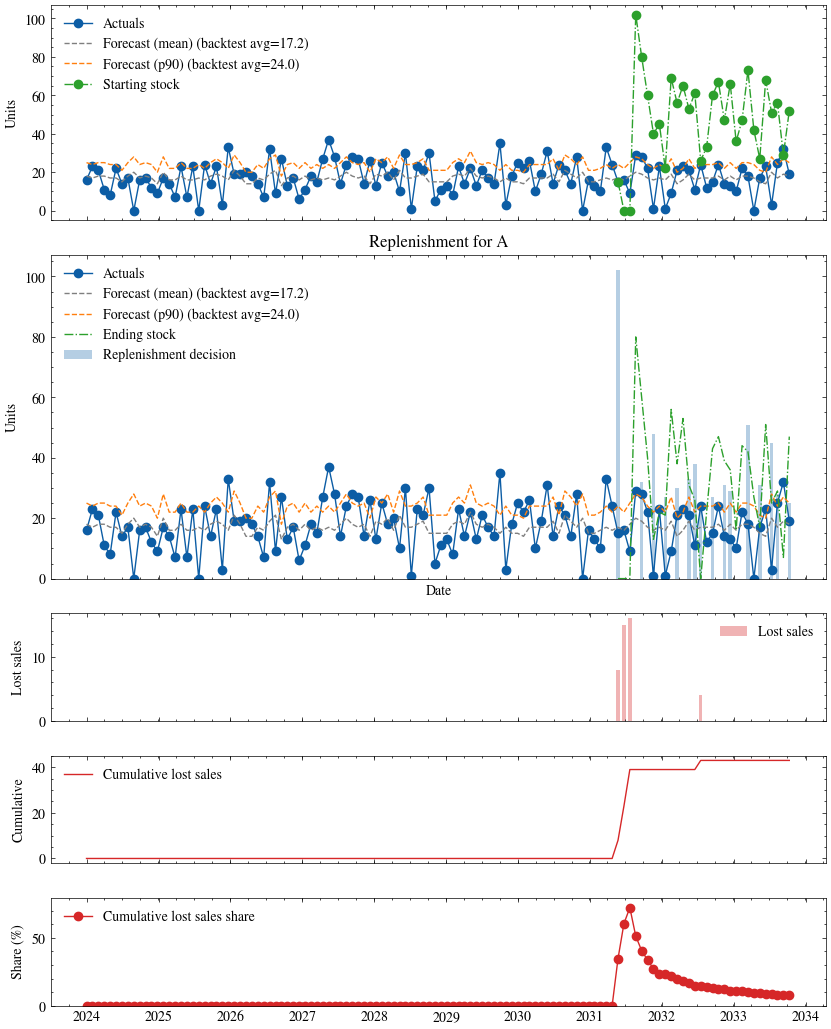

In [58]:
plot_replenishment_decisions(df, rop_percentile_decision_df, unique_id=example_id)


## ROP policy with aggregation window optimization
Uses time-aggregated optimization to select both window and percentile.


In [59]:
rop_agg_results = optimize_aggregation_and_forecast_targets(
    percentile_configs,
    candidate_windows=[7, 8, 9, 10],
    policy_mode="rop",
)
rop_agg_windows = {
    unique_id: result.window
    for unique_id, result in rop_agg_results.items()
}

rop_agg_forecast_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    review_period=rop_agg_windows,
    forecast_horizon=rop_agg_windows,
)
rop_agg_simulations = {}
for unique_id, config in rop_agg_forecast_configs.items():
    choice = rop_agg_results[unique_id]
    policy = RopPercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
        aggregation_window=choice.window,
    )
    rop_agg_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

rop_agg_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    rop_agg_simulations,
    aggregation_window={
        uid: rop_agg_results[uid].window
        for uid in rop_agg_simulations
    },
    percentile_target={
        uid: rop_agg_results[uid].target
        for uid in rop_agg_simulations
    },
    review_period=rop_agg_windows,
    forecast_horizon=rop_agg_windows,
    rmse_window=rop_agg_windows,
)
rop_agg_decision_df = replenishment_decision_rows_to_dataframe(
    rop_agg_decision_rows,
    library="pandas",
)
rop_agg_decision_df.head()


{'A': AggregationForecastTargetOptimizationResult(window=7, target='p90', policy=RopPercentileForecastOptimizationPolicy(forecast=[25, 24, 25, 25, 24, 24, 21, 25, 28, 24, 25, 24, 20, 28, 22, 22, 25, 22, 22, 24, 22, 25, 27, 25, 22, 29, 25, 20, 20, 24, 22, 27, 29, 18, 24, 25, 22, 25, 22, 24, 22, 24, 22, 25, 28, 25, 24, 25, 20, 27, 25, 28, 22, 29, 24, 24, 25, 27, 21, 21, 21, 21, 25, 27, 25, 31, 25, 24, 25, 24, 21, 24, 21, 21, 20, 24, 24, 24, 24, 27, 21, 29, 27, 24, 28, 21, 21, 22, 24, 22], lead_time=3, aggregation_window=7, review_period=7, forecast_horizon=7), simulation=SimulationResult(snapshots=[InventorySnapshot(period=0, starting_on_hand=15, demand=16, received=0, ending_on_hand=0, backorders=0, order_placed=245, on_order=245), InventorySnapshot(period=1, starting_on_hand=0, demand=23, received=0, ending_on_hand=0, backorders=0, order_placed=0, on_order=245), InventorySnapshot(period=2, starting_on_hand=0, demand=21, received=0, ending_on_hand=0, backorders=0, order_placed=0, on_ord

In [60]:
rop_agg_forecast_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    review_period=review_period,
    forecast_horizon=forecast_horizon,
)
rop_agg_simulations = {}
for unique_id, config in rop_agg_forecast_configs.items():
    choice = rop_agg_results[unique_id]
    policy = RopPercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
        aggregation_window=choice.window,
    )
    rop_agg_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
rop_agg_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    rop_agg_simulations,
    aggregation_window={
        uid: rop_agg_results[uid].window
        for uid in rop_agg_simulations
    },
    percentile_target={
        uid: rop_agg_results[uid].target
        for uid in rop_agg_simulations
    },
    review_period=review_period,
    forecast_horizon=forecast_horizon,
    rmse_window=rmse_window,
)
rop_agg_decision_df = replenishment_decision_rows_to_dataframe(
    rop_agg_decision_rows,
    library="pandas",
)
rop_agg_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,A,2031-05-24,241,23,23.666667,50.000000,71.0,142.0,0,15,...,0,241,0,8,None,3,3,3,3,p90
1,A,2031-06-23,0,15,25.000000,49.333333,75.0,150.0,0,0,...,0,241,0,15,None,3,3,3,3,p90
2,A,2031-07-23,0,16,26.666667,50.000000,80.0,160.0,0,0,...,0,241,0,16,None,3,3,3,3,p90
3,A,2031-08-22,0,22,26.333333,49.000000,79.0,158.0,241,241,...,219,0,0,0,None,3,3,3,3,p90
4,A,2031-09-21,0,20,24.333333,48.666667,73.0,146.0,0,219,...,199,0,0,0,None,3,3,3,3,p90


0      8
1     15
2     16
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     2
15    11
16    17
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Replenishment for A'}, xlabel='Date', ylabel='Units'>

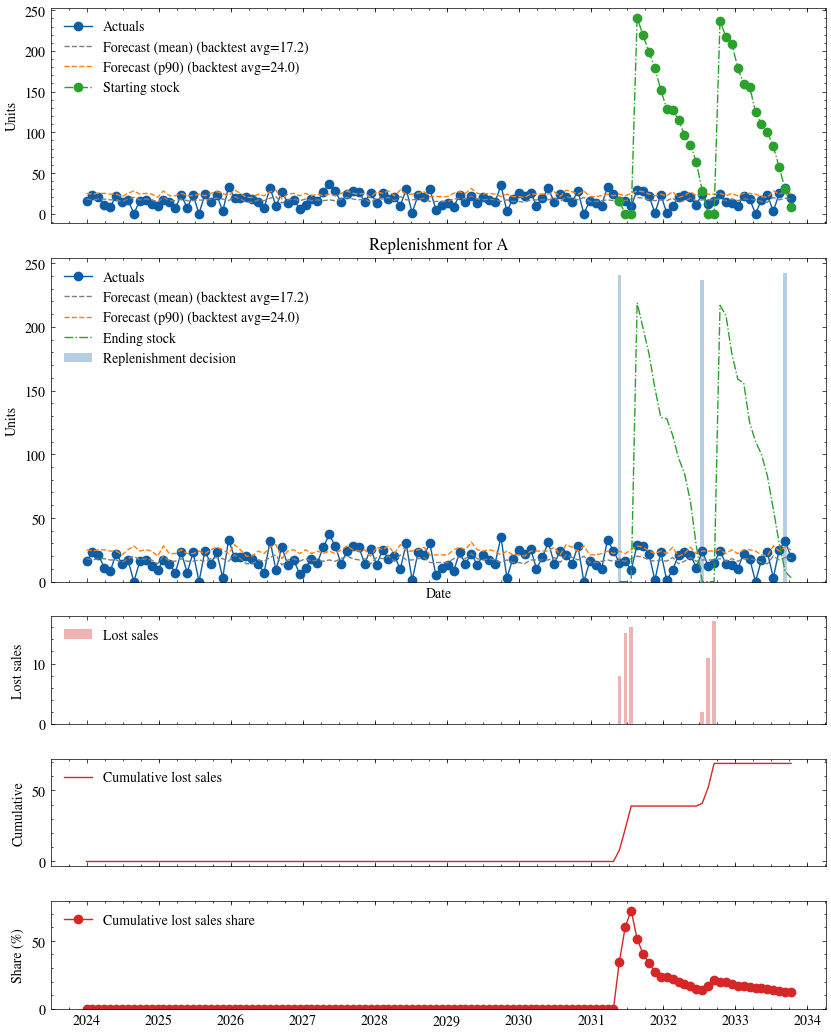

In [61]:
plot_replenishment_decisions(df, rop_agg_decision_df, unique_id=example_id)
